In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pylab 
import requests
import scipy.stats as stats
import seaborn as sb
import time
from xml.etree import ElementTree as ET

In [2]:
# Lines of code used for checking code:

# response = requests.get('https://www.boardgamegeek.com/xmlapi2/thing?id=13')
# tree = ET.fromstring(response.content)
# List of all the elements
#[elem.tag for elem in tree.iter()]
# See the whole text in XML format
#print(ET.tostring(tree, encoding='utf8').decode('utf8'))

## Code to pull boardgame info

In [3]:
# Creating a function to get the boardgame data from each page

def boardgame_info(tree):
    
    id_num = int(tree[0].attrib['id'])
    boardgamecategory = []
    boardgamemechanic = []
    boardgamedesigner = []
    
    for i in range(len(tree[0])):
        
        if tree[0][i].tag == 'name':
            if tree[0][i].attrib['type'] == 'primary':
                boardgame_name = tree[0][i].attrib['value']
                
        elif tree[0][i].tag == 'yearpublished':
            year_publ = int(tree[0][i].attrib['value'])
            
        elif tree[0][i].tag == 'minplayers':
            minplayers = int(tree[0][i].attrib['value'])
            
        elif tree[0][i].tag == 'maxplayers':
            maxplayers = int(tree[0][i].attrib['value'])   
            
        elif tree[0][i].tag == 'playingtime':
            playingtime = int(tree[0][i].attrib['value']) 
            
        elif tree[0][i].tag == 'minplaytime':
            minplaytime = int(tree[0][i].attrib['value']) 
            
        elif tree[0][i].tag == 'maxplaytime':
            maxplaytime = int(tree[0][i].attrib['value'])
            
        elif tree[0][i].tag == 'link':
            
            if tree[0][i].attrib['type'] == 'boardgamecategory':
                boardgamecategory.append(tree[0][i].attrib['value'])
                
            elif tree[0][i].attrib['type'] == 'boardgamemechanic':
                boardgamemechanic.append(tree[0][i].attrib['value'])
                
            elif tree[0][i].attrib['type'] == 'boardgamedesigner':
                boardgamedesigner.append(tree[0][i].attrib['value'])
     
    keys = ['game ID#', 'boardgame', 'year published', 'min players', 'max players', 'playing time', 'min playing time', 'max playing time', 'category', 'boardgame mechanic', 'boardgamedesigner']
    values = [id_num, boardgame_name, year_publ, minplayers, maxplayers, playingtime, minplaytime, maxplaytime, boardgamecategory, boardgamemechanic, boardgamedesigner]
    dictionary = dict(zip(keys, values))

    return dictionary           

## Code to pull boardgame ratings

In [5]:
# Lines of code used for checking code:

# ratings_response = requests.get('https://www.boardgamegeek.com/xmlapi2/thing?id=13&ratingcomments=1&page=1')
# ratings_tree = ET.fromstring(ratings_response.content)

In [4]:
# Creating a function to get the boardgame ratings

def get_ratings_per_page(ratings_tree):
        
    # Figuring out the number of ratings pages
    for i in range(len(ratings_tree[0])):
        if ratings_tree[0][i].tag == 'comments':
            ratings_info = i
            num_ratings = float(ratings_tree[0][i].attrib['totalitems'])
    #print(ratings_info)

    all_local_ratings = []
    for i in range(len(ratings_tree[0][ratings_info])):

        username = ratings_tree[0][ratings_info][i].attrib['username']
        rating = float(ratings_tree[0][ratings_info][i].attrib['rating'])     

        ratings_keys = ['username', 'rating']
        ratings_values = [username, rating]
        ratings_dictionary = dict(zip(ratings_keys, ratings_values))
        
        all_local_ratings.append(ratings_dictionary)
        
        #print(ratings_dictionary)
    return all_local_ratings

In [6]:
def get_all_ratings(ID):
    
    site = 'https://www.boardgamegeek.com/xmlapi2/thing?id='
    page_num = ID   
    ratings_site = '&ratingcomments=1&page='
    ratings_page_num_1 = 1
       
    ratings_website = site + str(page_num) + ratings_site + str(ratings_page_num_1)
    ratings_response = requests.get(ratings_website)
    ratings_tree = ET.fromstring(ratings_response.content)
        
   
    # Figuring out the number of ratings pages
    num_ratings = 0
    for j in range(len(ratings_tree[0])):
        if ratings_tree[0][j].tag == 'comments':
            num_ratings = float(ratings_tree[0][j].attrib['totalitems'])
    #print(num_ratings)
    
    num_pages = round(num_ratings/100)
    if num_pages < num_ratings/100:
        num_pages += 1
    #print(num_pages)

    all_ratings = []
    for k in range(num_pages):
        ratings_website2 = site + str(page_num) + ratings_site + str(k+1)
        ratings_response2 = requests.get(ratings_website2)
        ratings_tree2 = ET.fromstring(ratings_response2.content)
        #print(k, ratings_website2)
        all_ratings.append(get_ratings_per_page(ratings_tree2))
        time.sleep(2)        
    return all_ratings

## Pulling all info and ratings of multiple games

In [7]:
def get_all_game_info(ID):
    
    # boardgame websites
    site = 'https://www.boardgamegeek.com/xmlapi2/thing?id='
    page_num = ID
    website = site+str(page_num)        
    response = requests.get(website)
    tree = ET.fromstring(response.content)
       
    ratings_site = '&ratingcomments=1&page='
    ratings_page_num_1 = 1
       
    ratings_website = site + str(page_num) + ratings_site + str(ratings_page_num_1)
    ratings_response = requests.get(ratings_website)
    ratings_tree = ET.fromstring(ratings_response.content) 

    bg_info = boardgame_info(tree)
    bg_ratings = get_all_ratings(ID)
    bg_info['ratings'] = bg_ratings
    time.sleep(5)         

    
    return bg_info

## Pulling all info from BoardGameGeek's API

In [ ]:
for ID in range(1,50001):
    site = 'https://www.boardgamegeek.com/xmlapi2/thing?id='
    page_num = ID
    website = site+str(page_num)        
    response = requests.get(website)
    tree = ET.fromstring(response.content)

    if len(tree) > 0 and tree[0].attrib['type'] == 'boardgame':
        ind_bg = get_all_game_info(ID)
        #print(ID)
        with open('ind_bg_{0}.json'.format(ID), 'w') as json_file:
            json.dump(ind_bg, json_file)
    
    time.sleep(5)

In [27]:
# updating the path
path = 'C:/Users/Ariel/Desktop/BGG_JSON_files/'
os.chdir(path)

# Loop through all the json files in the forlder
ind_bg = []
for i in range(1,49984):
    
    if os.path.exists('ind_bg_{0}.json'.format(i)) == True:
        
        #open the file
        with open('ind_bg_{0}.json'.format(i)) as f:
          ind_bg_json = json.load(f)
        #ind_bg = pd.DataFrame.from_dict(ind_bg_json, orient = 'index').T
        ind_bg.append(ind_bg_json)

In [ ]:
# Path to save board_game_df.csv to 
path2 = 'C:/Users/Ariel/Desktop/01 DATA SCIENCE/Springboard/Capstone 1/'

# saving as csv
board_game_df.to_csv (path2+'board_game_df.csv', index = None, header=True) 

In [2]:
# Updating the path to get board_game_df.csv
file = 'C:/Users/Ariel/Desktop/01 DATA SCIENCE/Springboard/Capstone 1/'

# Loading board_game_df.csv
board_game_df = pd.read_csv(file+'board_game_df.csv', encoding = 'unicode_escape')

## Creating the new columns for "boardgame mechanic" one-hot encoding

In [3]:
# convert board_game_df['boardgame mechanic'] into a list(replace characters with blank)
# remove square braces, then split on commas (.split() to remove the commas)

bg_mechanic_list = []
bg_mechanic = set()
for i in range(len(board_game_df)):     #len(board_game_df['boardgame mechanic'])):
    bg_mechanic_list = board_game_df['boardgame mechanic'][i]\
                        .replace('[','')\
                        .replace(']','')\
                        .replace("'", '')\
                        .split(',')
    
    for j in bg_mechanic_list:
        element_string = j.strip()
        if element_string != '':
            bg_mechanic.add(element_string)

In [4]:
# saving the set as a list to create the individual columns
unique_bg_mechanic_list = list(bg_mechanic)

# Creating the columns for boardgame mechanic 
for i in range(len(unique_bg_mechanic_list)):
    board_game_df['bg mechanic {0}'.format(unique_bg_mechanic_list[i])] = np.nan

In [7]:
# Filling in the boardgame mechanic columns using one-hot encoding
for i in range(len(board_game_df)):
    for j in range(len(unique_bg_mechanic_list)):
        if unique_bg_mechanic_list[j] in board_game_df['boardgame mechanic'][i]:
            board_game_df.loc[i, 'bg mechanic '+str(unique_bg_mechanic_list[j])] = 1
        else:
            board_game_df.loc[i,'bg mechanic '+str(unique_bg_mechanic_list[j])] = 0

## Creating the new columns for "category" one-hot encoding

In [12]:
# convert board_game_df['category'] into a list(replace characters with blank)
# remove square braces, then split on commas (.split() to remove the commas)

bg_category_list = []
bg_category = set()
for i in range(len(board_game_df)):     #len(board_game_df['boardgame mechanic'])):
    bg_category_list = board_game_df['category'][i]\
                        .replace('[','')\
                        .replace(']','')\
                        .replace("'", '')\
                        .replace('"', '')\
                        .split(',')
    
    for j in bg_category_list:
        element_string = j.strip()
        if element_string != '':
            bg_category.add(element_string)

In [15]:
# saving the set as a list to create the individual columns
unique_bg_category_list = list(bg_category)

# Creating the columns for categories 
for i in range(len(unique_bg_category_list)):
    board_game_df['bg category {0}'.format(unique_bg_category_list[i])] = np.nan

In [18]:
# Filling in the category columns using one-hot encoding
for i in range(len(board_game_df)):
    
    for j in range(len(unique_bg_category_list)):
        
        if unique_bg_category_list[j] in board_game_df['category'][i]:
            board_game_df.loc[i, 'bg category '+str(unique_bg_category_list[j])] = 1
            
        else:
            board_game_df.loc[i,'bg category '+str(unique_bg_category_list[j])] = 0

In [ ]:
## Filling in the boardgame mechanic columns using one-hot encoding
#for i in range(len(board_game_df)):
#    for j in range(len(unique_bg_mechanic_list)):
#            board_game_df.loc[i, 'bg mechanic '+str(unique_bg_mechanic_list[j])] = int(unique_bg_mechanic_list[j] in board_game_df['boardgame mechanic'][i])

## Creating the new columns for average ratings and the number of ratings per game

In [26]:
# Function to create/calculate each boardgame's average rating
def ratings_stats(var1):
    # Converting the ratings column from a string to a list of dictionaries
    ratings = json.loads(var1.replace("'", "\""))
    
    # Calculating the average rating per game
    sum_ratings = 0
    count_ratings = 0
    for i in range(len(ratings)):
        for j in range(len(ratings[i])):
            sum_ratings += ratings[i][j]['rating']
            count_ratings += 1
            
    if count_ratings != 0:
        avg_ratings = sum_ratings/count_ratings
    else:
        avg_ratings = 0     
            
    return "{:.2f}".format(avg_ratings) 

# Using map() to call the 'ratings_star' function and create the average rating column
board_game_df['average rating'] = board_game_df['ratings'].map(ratings_stats)

In [27]:
# Function to create/calculate each boardgame's total number of ratings
def num_ratings(var1):
    # Converting the ratings column from a string to a list of dictionaries
    ratings = json.loads(var1.replace("'", "\""))
    
    # Calculating the total number of ratings per game
    count_ratings = 0
    for i in range(len(ratings)):
        for j in range(len(ratings[i])):
            count_ratings += 1
            
    return count_ratings

# Using map() to call the 'num_ratings' function and create the number of ratings column
board_game_df['number of ratings'] = board_game_df['ratings'].map(num_ratings)

Saving board_game_df with the new columns

In [31]:
# Path to save board_game_df.csv to 
path2 = 'C:/Users/Ariel/Desktop/01 DATA SCIENCE/Springboard/Capstone 1/'

# saving as csv
board_game_df.to_csv (path2+'board_game_df2.csv', index = None, header=True) 

# Data Storytelling 

In [40]:
# Updating the path to get board_game_df.csv
file = 'C:/Users/Ariel/Desktop/01 DATA SCIENCE/Springboard/Capstone 1/'

# Loading board_game_df.csv
board_game_df = pd.read_csv(file+'board_game_df2.csv', encoding = 'unicode_escape')

In [41]:
# Converting the "average rating" column from string to float
board_game_df['average rating'] = board_game_df['average rating'].astype(float)

Boardgames with an average rating of zero were replaced with NaN so they won't skew the statistics.

In [42]:
# Number of board games with zero ratings. 
print('Number of board games with no ratings:', (board_game_df['average rating'] == 0).sum())

Number of board games with no ratings: 7206


In [43]:
num_of_ratings = [1,2,3,4,5,10,20,30,50,100]

for i in range(len(num_of_ratings)):
    
    count = 0
    for j in range(len(board_game_df)):
        
        if board_game_df['number of ratings'][j] < num_of_ratings[i]:
            count += 1
            
    if i == 0:
        print('Board games with', num_of_ratings[i]-1,'ratings:', count,',', "{:.2f}".format((count/37730)* 100),\
              'percent of the data')
    else:
        print('Board games with less than', num_of_ratings[i],'ratings:', count,',', "{:.2f}".format((count/37730)* 100),\
              'percent of the data')

Board games with 0 ratings: 7206 , 19.10 percent of the data
Board games with less than 2 ratings: 11792 , 31.25 percent of the data
Board games with less than 3 ratings: 15097 , 40.01 percent of the data
Board games with less than 4 ratings: 17427 , 46.19 percent of the data
Board games with less than 5 ratings: 19130 , 50.70 percent of the data
Board games with less than 10 ratings: 23731 , 62.90 percent of the data
Board games with less than 20 ratings: 27220 , 72.14 percent of the data
Board games with less than 30 ratings: 28890 , 76.57 percent of the data
Board games with less than 50 ratings: 30800 , 81.63 percent of the data
Board games with less than 100 ratings: 32978 , 87.41 percent of the data


In [45]:
# Removing board games with zero ratings so they don't skew the mean of rated games
board_game_df_AvgRating_NonZero = board_game_df[board_game_df['average rating'] > 0]

# Removing board games that have less than 2 ratings
board_game_df_NumRatings_2 = board_game_df[board_game_df['number of ratings'] > 1] 

# Removing board games that have less than 3 ratings
board_game_df_NumRatings_3 = board_game_df[board_game_df['number of ratings'] > 2] 

# Removing board games that have less than 4 ratings
board_game_df_NumRatings_4 = board_game_df[board_game_df['number of ratings'] > 3] 

# Removing board games that have less than 5 ratings
board_game_df_NumRatings_5 = board_game_df[board_game_df['number of ratings'] > 4]

# Removing board games that have less than 10 ratings
board_game_df_NumRatings_10 = board_game_df[board_game_df['number of ratings'] > 9]

# Removing board games that have less than 30 ratings
board_game_df_NumRatings_30 = board_game_df[board_game_df['number of ratings'] > 29]


In [50]:
def means_medians(df):
    print('Mean average-ratings:', float("{:.3f}".format(df['average rating'].mean())))
    print('Median average-ratings:', float("{:.3f}".format(df['average rating'].median())))
    print('Mean number of ratings:', float("{:.3f}".format(df['number of ratings'].mean())))
    print('Median number of ratings:', float("{:.3f}".format(df['number of ratings'].median())))
    print('\n')

print('board_game_df_AvgRating_NonZero:')
means_medians(board_game_df_AvgRating_NonZero)

print('board_game_df_NumRatings_2:')
means_medians(board_game_df_NumRatings_2)

print('board_game_df_NumRatings_3:')
means_medians(board_game_df_NumRatings_3)

print('board_game_df_NumRatings_4:')
means_medians(board_game_df_NumRatings_4)

print('board_game_df_NumRatings_5:')
means_medians(board_game_df_NumRatings_5)

print('board_game_df_NumRatings_10:')
means_medians(board_game_df_NumRatings_10)

print('board_game_df_NumRatings_30:')
means_medians(board_game_df_NumRatings_30)


board_game_df_AvgRating_NonZero:
Mean average-ratings: 5.455
Median average-ratings: 5.61
Mean number of ratings: 223.182
Median number of ratings: 8.0


board_game_df_NumRatings_2:
Mean average-ratings: 5.558
Median average-ratings: 5.67
Mean number of ratings: 262.465
Median number of ratings: 12.0


board_game_df_NumRatings_3:
Mean average-ratings: 5.632
Median average-ratings: 5.74
Mean number of ratings: 300.499
Median number of ratings: 16.0


board_game_df_NumRatings_4:
Mean average-ratings: 5.692
Median average-ratings: 5.79
Mean number of ratings: 334.641
Median number of ratings: 21.0


board_game_df_NumRatings_5:
Mean average-ratings: 5.742
Median average-ratings: 5.82
Mean number of ratings: 364.914
Median number of ratings: 26.0


board_game_df_NumRatings_10:
Mean average-ratings: 5.873
Median average-ratings: 5.93
Mean number of ratings: 482.67
Median number of ratings: 48.0


board_game_df_NumRatings_30:
Mean average-ratings: 6.068
Median average-ratings: 6.11
Mean numbe

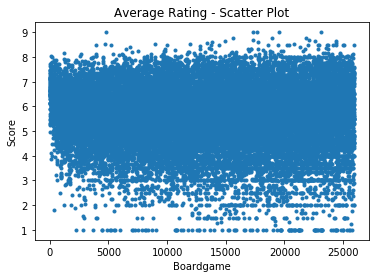

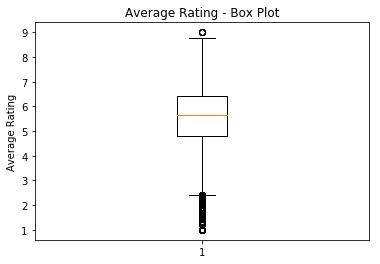

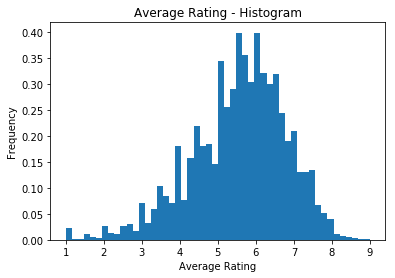

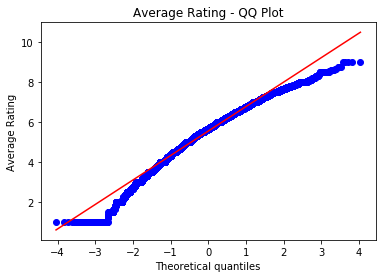

In [52]:
y = np.array(board_game_df_NumRatings_2['average rating'])

# scatter plot
plt.plot(y, marker='.', linestyle='none')
plt.title('Average Rating - Scatter Plot')
plt.xlabel('Boardgame')
plt.ylabel('Score')
plt.show()

# boxplot
plt.boxplot(y)
plt.title('Average Rating - Box Plot')
plt.ylabel('Average Rating')
plt.show()

# histogram
plt.hist(y, normed=True, bins = 50)
plt.title('Average Rating - Histogram')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

# qq-plot
stats.probplot(y, dist="norm", plot=pylab)
plt.title('Average Rating - QQ Plot')
plt.ylabel('Average Rating')
pylab.show()

The average rating scatter plot shows that most of the scores users gave to the games is between 2 and 8. Outside these bounds there are manyoutliers, however, the majority of the games are rated within the range. The box plot also shows that the majority of the average ratings for each game are in the same 2 to 8 range. 

The histogram and the qq-plot show that the average rating

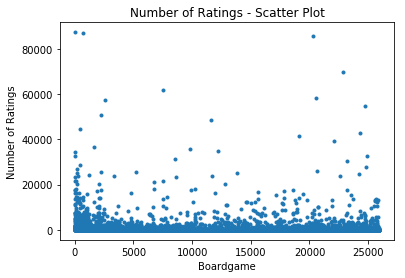

In [53]:
y = np.array(board_game_df_NumRatings_2['number of ratings'])

# scatter plot
plt.plot(y, marker='.', linestyle='none')
plt.title('Number of Ratings - Scatter Plot')
plt.xlabel('Boardgame')
plt.ylabel('Number of Ratings')
plt.show()

In [54]:
print("Correlation between a boardgame's average rating and its number of ratings:",\
      "{:.3f}".format(board_game_df_NumRatings_2['average rating']\
                      .corr(board_game_df_NumRatings_2['number of ratings'])))

Correlation between a boardgame's average rating and its number of ratings: 0.129


In [63]:
# Top 20 rated games
board_game_df_NumRatings_2.sort_values('average rating', ascending=False)[1:21]

,boardgame,boardgame mechanic,boardgamedesigner,category,game ID#,max players,max playing time,min players,min playing time,playing time,...,bg category American Civil War,bg category Abstract Strategy,bg category Transportation,bg category Comic Book / Strip,bg category Vietnam War,bg category Korean War,bg category Expansion for Base-game,bg category Card Game,average rating,number of ratings
21467,Mach Speed Hunters,['Dice Rolling'],['David North (II)'],"['Korean War', 'Miniatures', 'Modern Warfare',...",24699,6,0,2,0,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,9.00,4
4945,Wedago: The Warriors Circle,"['Acting', 'Rock-Paper-Scissors']",['Patrick Ouvrard'],"['Action / Dexterity', ""Children's Game"", 'Fig...",5706,2,20,2,20,20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.00,2
22095,Panama,[],['Philippe Beaudoin'],['Industry / Manufacturing'],25398,5,90,3,90,90,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.00,2
25164,Hannibal: The War of the Kings,['Area Enclosure'],['(Uncredited)'],['Abstract Strategy'],28923,2,0,2,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9.00,2
18900,In Clouds of Glory,"['Area Control / Area Influence', 'Cooperative...","['Thomas Greve', 'Svend Ask Larsen']","['Aviation / Flight', 'Miniatures', 'Wargame',...",21706,8,180,2,180,180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.75,14
24234,StarBlazers Fleet Simulator,[],['Karl Hiesterman'],"['Miniatures', 'Science Fiction', 'Wargame']",27865,2,0,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.75,2
29587,Great War,"['Action Point Allowance System', 'Dice Rolling']","['Fred Haub', 'Terry Sirk']","['Miniatures', 'Wargame', 'World War I']",34034,2,120,2,120,120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.75,2
30175,Cribble,"['Betting/Wagering', 'Set Collection']",['(Uncredited)'],['Card Game'],34724,4,0,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.67,3
21469,MiG Hunters,['Dice Rolling'],['David North (II)'],"['Miniatures', 'Wargame']",24701,6,0,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.67,3
17818,RPGQuest: Greek Mythology,"['Action Point Allowance System', 'Cooperative...","['Ronaldo Barata', 'Norson Botrel', 'Marcelo D...","['Exploration', 'Fantasy']",20414,12,30,4,30,30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.63,46


In [62]:
# Top 20 games witht the most ratings
board_game_df_NumRatings_2.sort_values('number of ratings', ascending=False)[1:21]

,boardgame,boardgame mechanic,boardgamedesigner,category,game ID#,max players,max playing time,min players,min playing time,playing time,...,bg category American Civil War,bg category Abstract Strategy,bg category Transportation,bg category Comic Book / Strip,bg category Vietnam War,bg category Korean War,bg category Expansion for Base-game,bg category Card Game,average rating,number of ratings
718,Carcassonne,"['Area Control / Area Influence', 'Tile Placem...",['Klaus-Jürgen Wrede'],"['City Building', 'Medieval', 'Territory Build...",822,5,45,2,30,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.43,86872
26594,Pandemic,"['Action Point Allowance System', 'Cooperative...",['Matt Leacock'],['Medical'],30549,4,45,2,45,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.63,85770
31504,Dominion,"['Card Drafting', 'Deck / Pool Building', 'Han...",['Donald X. Vaccarino'],"['Card Game', 'Medieval']",36218,4,30,2,30,30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.64,69688
8011,Ticket to Ride,"['Card Drafting', 'Hand Management', 'Route/Ne...",['Alan R. Moon'],['Trains'],9209,5,60,2,30,60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.44,61775
27193,Agricola,"['Area Enclosure', 'Card Drafting', 'Hand Mana...",['Uwe Rosenberg'],"['Animals', 'Economic', 'Farming']",31260,5,150,1,30,150,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.98,58187
2632,Puerto Rico,['Variable Phase Order'],['Andreas Seyfarth'],"['City Building', 'Economic', 'Farming']",3076,5,150,3,90,150,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.03,57481
35343,Small World,"['Area Control / Area Influence', 'Area Moveme...",['Philippe Keyaerts'],"['Fantasy', 'Fighting', 'Territory Building']",40692,5,80,2,40,80,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.30,54640
2269,Power Grid,"['Auction/Bidding', 'Route/Network Building']",['Friedemann Friese'],"['Economic', 'Industry / Manufacturing']",2651,6,120,2,120,120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.89,50939
13149,Ticket to Ride: Europe,"['Card Drafting', 'Hand Management', 'Route/Ne...",['Alan R. Moon'],['Trains'],14996,5,60,2,30,60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.56,48708
416,Citadels,"['Card Drafting', 'Set Collection', 'Variable ...",['Bruno Faidutti'],"['Bluffing', 'Card Game', 'City Building', 'Fa...",478,8,60,2,20,60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.10,44430
